In [20]:
import scprep
import pandas as pd
import numpy as np

spleen_counts_path = "Spleen-counts.csv"
liver_counts_path = "Liver-counts.csv"
metadata_path = "metadata_FACS.csv"  

spleen_data = scprep.io.load_csv(spleen_counts_path, cell_axis='row').transpose()
liver_data = scprep.io.load_csv(liver_counts_path, cell_axis='row').transpose()


In [21]:
import pandas as pd

spleen_data['tissue'] = 'Spleen'
liver_data['tissue'] = 'Liver'

combined_data = pd.concat([spleen_data, liver_data], ignore_index=False) 

print("Spleen shape:", spleen_data.shape)
print("Liver shape:", liver_data.shape)
print("Combined data shape:", combined_data.shape)

print(combined_data.head())


Spleen shape: (1718, 23434)
Liver shape: (981, 23434)
Combined data shape: (2699, 23434)
                         0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A21.MAA000508.3_9_M.1.1            0.0           36.0            0.0   
C6.MAA000508.3_9_M.1.1             0.0            0.0            0.0   
A22.MAA000508.3_9_M.1.1            0.0            0.0            0.0   
C8.MAA000508.3_9_M.1.1             0.0           27.0            0.0   
E8.MAA000508.3_9_M.1.1             0.0            0.0            0.0   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A21.MAA000508.3_9_M.1.1            0.0           36.0            0.0   
C6.MAA000508.3_9_M.1.1             0.0            0.0           31.0   
A22.MAA000508.3_9_M.1.1            0.0            6.0            0.0   
C8.MAA000508.3_9_M.1.1             0.0            0.0            0.0   
E8.MAA000508.3_9_M.1.1             0.0            0.0            0.0   

                         0610007P22Rik  06100

In [22]:

non_zero_genes = combined_data.drop('tissue', axis=1).columns[combined_data.drop('tissue', axis=1).sum(axis=0) > 0]
non_zero_genes = combined_data.drop(columns=['tissue']).columns[combined_data.drop(columns=['tissue']).sum(axis=0) > 0]
filtered_data = combined_data.loc[:, list(non_zero_genes) + ['tissue']]

print("Filtered data shape:", filtered_data.shape)


Filtered data shape: (2699, 19227)


In [23]:
percentiles = (2.5, 97.5)

filtered_data = scprep.filter.filter_library_size(
    filtered_data.drop(columns=['tissue']), percentile=percentiles
)

filtered_data['tissue'] = combined_data['tissue']
print("Filtered data shape (after percentile filtering):", filtered_data.shape)


Filtered data shape (after percentile filtering): (2562, 19227)


In [24]:
import numpy as np

log_transformed_data = filtered_data.drop(columns=['tissue']).applymap(lambda x: np.log1p(x))
log_transformed_data['tissue'] = filtered_data['tissue']
print("Log-transformed data shape:", log_transformed_data.shape)
print(log_transformed_data.head())


Log-transformed data shape: (2562, 19227)
                         0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A21.MAA000508.3_9_M.1.1            0.0       3.610918            0.0   
C6.MAA000508.3_9_M.1.1             0.0       0.000000            0.0   
A22.MAA000508.3_9_M.1.1            0.0       0.000000            0.0   
C8.MAA000508.3_9_M.1.1             0.0       3.332205            0.0   
E8.MAA000508.3_9_M.1.1             0.0       0.000000            0.0   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A21.MAA000508.3_9_M.1.1            0.0       3.610918       0.000000   
C6.MAA000508.3_9_M.1.1             0.0       0.000000       3.465736   
A22.MAA000508.3_9_M.1.1            0.0       1.945910       0.000000   
C8.MAA000508.3_9_M.1.1             0.0       0.000000       0.000000   
E8.MAA000508.3_9_M.1.1             0.0       0.000000       0.000000   

                         0610007P22Rik  0610008F07Rik  0610009B22Rik  \
A21.MAA000508.3_9_M.

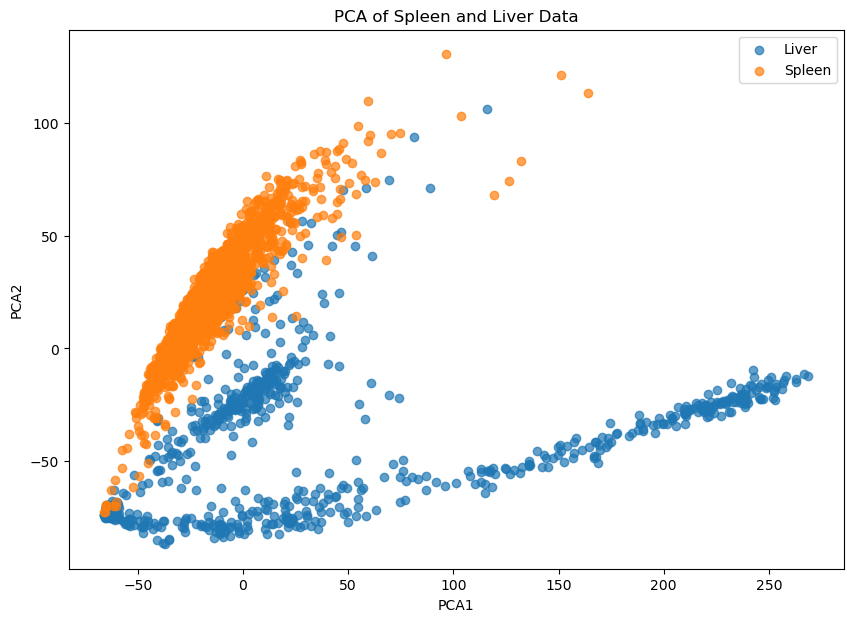

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

normalized_data =log_transformed_data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data.drop(columns=['tissue']))
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['tissue'] = normalized_data['tissue'].values

plt.figure(figsize=(10, 7))
for tissue, group in pca_df.groupby('tissue'):
    plt.scatter(group['PCA1'], group['PCA2'], label=tissue, alpha=0.7)
plt.title("PCA of Spleen and Liver Data")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

In [26]:
mean_expression = normalized_data.groupby('tissue').mean()

fold_change = mean_expression.loc['Spleen'] - mean_expression.loc['Liver']

top_genes = fold_change.sort_values(ascending=False).head(10)
print("Top upregulated genes in Spleen:\n", top_genes)

bottom_genes = fold_change.sort_values(ascending=True).head(10)
print("Top upregulated genes in Liver:\n", bottom_genes)


Top upregulated genes in Spleen:
 Coro1a     5.744841
Cd74       5.398221
H2-Ab1     5.270938
H2-Aa      5.166415
Rac2       5.098263
Cd79a      4.964855
Cd79b      4.803511
H2-Eb1     4.800670
Cd52       4.787350
Ptprcap    4.765207
dtype: float64
Top upregulated genes in Liver:
 Alb         -5.167793
Trf         -5.042447
Apoe        -4.835630
Sepp1       -4.772929
Apoa1       -4.753885
Serpina3k   -4.673610
Mup3        -4.544561
Apoa2       -4.390439
Hpx         -4.304484
Gc          -4.202039
dtype: float64


Marker genes for visualization: ['Coro1a', 'Cd74', 'H2-Ab1', 'H2-Aa', 'Rac2']


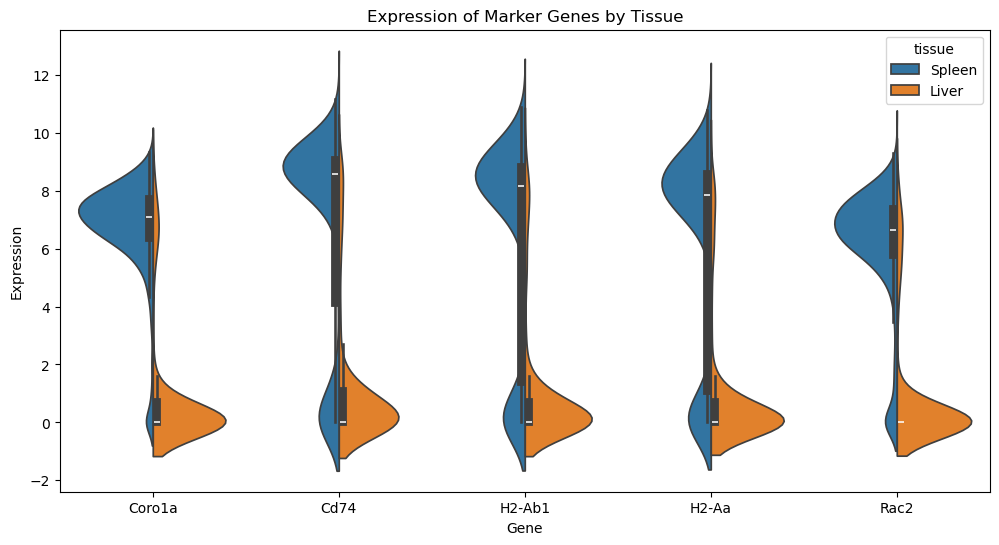

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

marker_genes = list(top_genes.index[:5])  # Adjust as needed
print("Marker genes for visualization:", marker_genes)

melted_data = normalized_data.loc[:, marker_genes + ['tissue']].melt(
    id_vars=['tissue'], var_name='Gene', value_name='Expression'
)

plt.figure(figsize=(12, 6))
sns.violinplot(x='Gene', y='Expression', hue='tissue', data=melted_data, split=True)
plt.title("Expression of Marker Genes by Tissue")
plt.show()


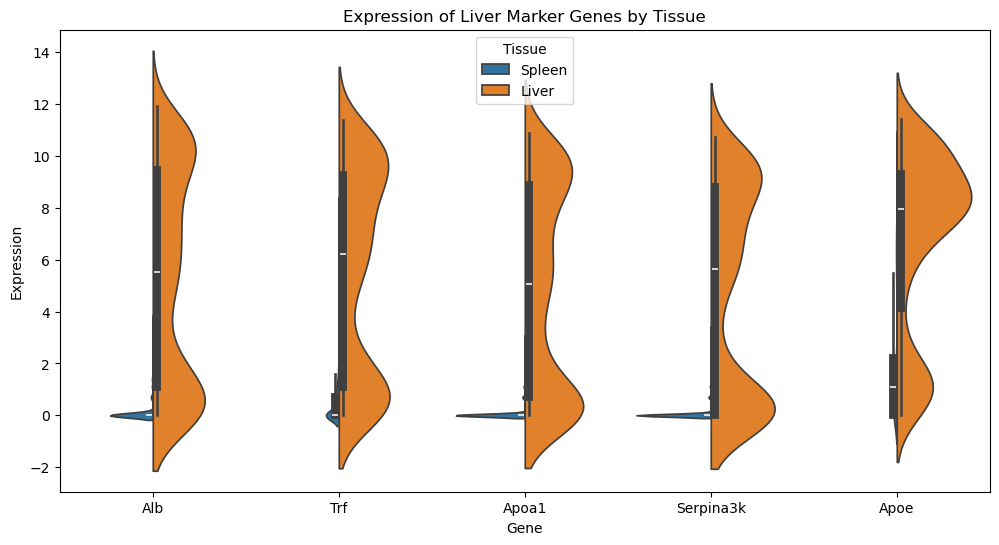

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

liver_marker_genes = ['Alb', 'Trf', 'Apoa1', 'Serpina3k', 'Apoe']

liver_melted_data = normalized_data.loc[:, liver_marker_genes + ['tissue']].melt(
    id_vars=['tissue'], var_name='Gene', value_name='Expression'
)

plt.figure(figsize=(12, 6))
sns.violinplot(x='Gene', y='Expression', hue='tissue', data=liver_melted_data, split=True)
plt.title("Expression of Liver Marker Genes by Tissue")
plt.xlabel("Gene")
plt.ylabel("Expression")
plt.legend(title="Tissue")
plt.show()


In [29]:
liver_data = normalized_data[normalized_data['tissue'] == 'Liver'].drop(columns=['tissue'])
print("Liver data shape:", liver_data.shape)


Liver data shape: (853, 19226)


In [30]:
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
liver_clusters = kmeans.fit_predict(liver_data)

liver_data_with_clusters = liver_data.copy()
liver_data_with_clusters['cluster'] = liver_clusters

print("Liver data with clusters:\n", liver_data_with_clusters.head())


/srv/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Liver data with clusters:
                          0610005C13Rik  0610007C21Rik  0610007L01Rik  \
F18.MAA000377.3_9_M.1.1            0.0       0.000000       3.178054   
J20.MAA000377.3_9_M.1.1            0.0       0.000000       0.000000   
F19.MAA000377.3_9_M.1.1            0.0       0.000000       0.000000   
J21.MAA000377.3_9_M.1.1            0.0       0.000000       0.000000   
F20.MAA000377.3_9_M.1.1            0.0       1.098612       0.000000   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
F18.MAA000377.3_9_M.1.1            0.0            0.0            0.0   
J20.MAA000377.3_9_M.1.1            0.0            0.0            0.0   
F19.MAA000377.3_9_M.1.1            0.0            0.0            0.0   
J21.MAA000377.3_9_M.1.1            0.0            0.0            0.0   
F20.MAA000377.3_9_M.1.1            0.0            0.0            0.0   

                         0610007P22Rik  0610008F07Rik  0610009B22Rik  \
F18.MAA000377.3_9_M.1.1            

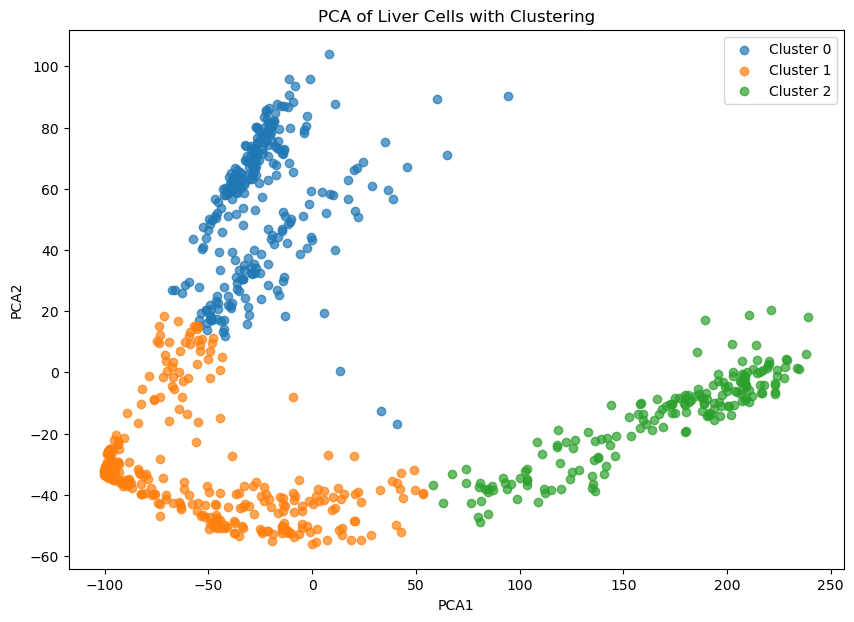

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
liver_pca_result = pca.fit_transform(liver_data)

pca_df = pd.DataFrame(liver_pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = liver_clusters

plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    plt.scatter(
        pca_df[pca_df['cluster'] == cluster]['PCA1'],
        pca_df[pca_df['cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title("PCA of Liver Cells with Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()


In [32]:
spleen_data = normalized_data[normalized_data['tissue'] == 'Spleen'].drop(columns=['tissue'])
print("Spleen data shape:", spleen_data.shape)


Spleen data shape: (1709, 19226)


In [33]:
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
spleen_clusters = kmeans.fit_predict(spleen_data)

spleen_data_with_clusters = spleen_data.copy()
spleen_data_with_clusters['cluster'] = spleen_clusters

print("Spleen data with clusters:\n", spleen_data_with_clusters.head())


/srv/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Spleen data with clusters:
                          0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A21.MAA000508.3_9_M.1.1            0.0       3.610918            0.0   
C6.MAA000508.3_9_M.1.1             0.0       0.000000            0.0   
A22.MAA000508.3_9_M.1.1            0.0       0.000000            0.0   
C8.MAA000508.3_9_M.1.1             0.0       3.332205            0.0   
E8.MAA000508.3_9_M.1.1             0.0       0.000000            0.0   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A21.MAA000508.3_9_M.1.1            0.0       3.610918       0.000000   
C6.MAA000508.3_9_M.1.1             0.0       0.000000       3.465736   
A22.MAA000508.3_9_M.1.1            0.0       1.945910       0.000000   
C8.MAA000508.3_9_M.1.1             0.0       0.000000       0.000000   
E8.MAA000508.3_9_M.1.1             0.0       0.000000       0.000000   

                         0610007P22Rik  0610008F07Rik  0610009B22Rik  \
A21.MAA000508.3_9_M.1.1           

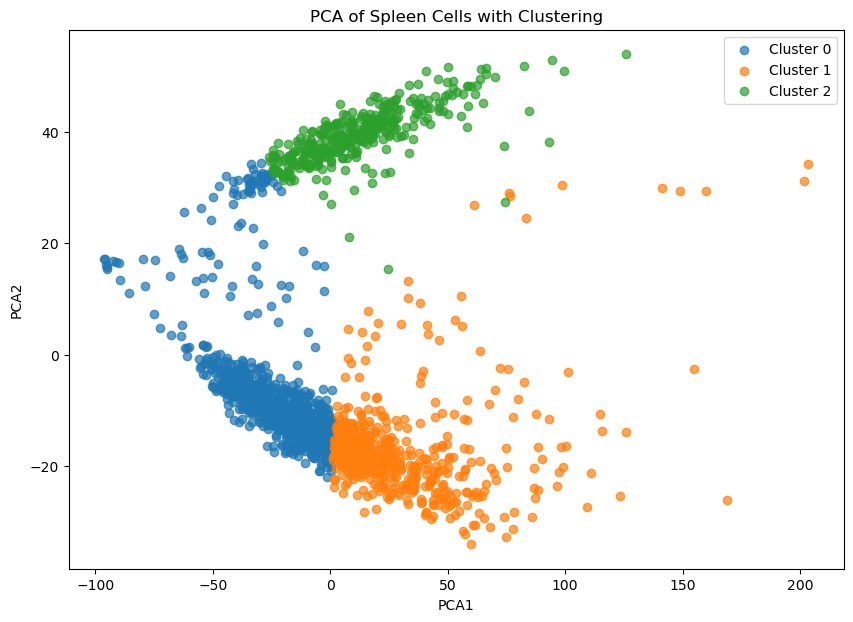

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
spleen_pca_result = pca.fit_transform(spleen_data)

spleen_pca_df = pd.DataFrame(spleen_pca_result, columns=['PCA1', 'PCA2'])
spleen_pca_df['cluster'] = spleen_clusters

plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    plt.scatter(spleen_pca_df[spleen_pca_df['cluster'] == cluster]['PCA1'],
        spleen_pca_df[spleen_pca_df['cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title("PCA of Spleen Cells with Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()


In [35]:
cluster_means = spleen_data_with_clusters.groupby('cluster').mean()

top_marker_genes_spleen = {}
for cluster in range(n_clusters):
    cluster_fold_change = cluster_means.loc[cluster] - cluster_means.mean()
    top_marker_genes_spleen[cluster] = cluster_fold_change.sort_values(ascending=False).head(5)
    print(f"Top marker genes for Cluster {cluster}:\n", top_marker_genes_spleen[cluster])


Top marker genes for Cluster 0:
 Cd74      2.139561
H2-Ab1    1.919679
H2-Aa     1.830702
H2-Eb1    1.638137
Cd79a     1.580630
dtype: float64
Top marker genes for Cluster 1:
 H2-Ab1    3.200679
H2-Aa     3.142503
Cd74      3.120277
Ms4a1     2.990177
H2-Eb1    2.972549
dtype: float64
Top marker genes for Cluster 2:
 Ms4a4b    4.042184
Lck       3.563845
Cd3g      3.276171
Cd3d      3.078103
Selplg    2.965585
dtype: float64


In [36]:
from sklearn.decomposition import PCA
data_pca = PCA(n_components=2).fit_transform(log_transformed_data.drop(columns=['tissue']))
data_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'], index=log_transformed_data.index)


import umap
data_umap = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(log_transformed_data.drop(columns=['tissue']))
data_umap = pd.DataFrame(data_umap, columns=['UMAP1', 'UMAP2'], index=log_transformed_data.index)


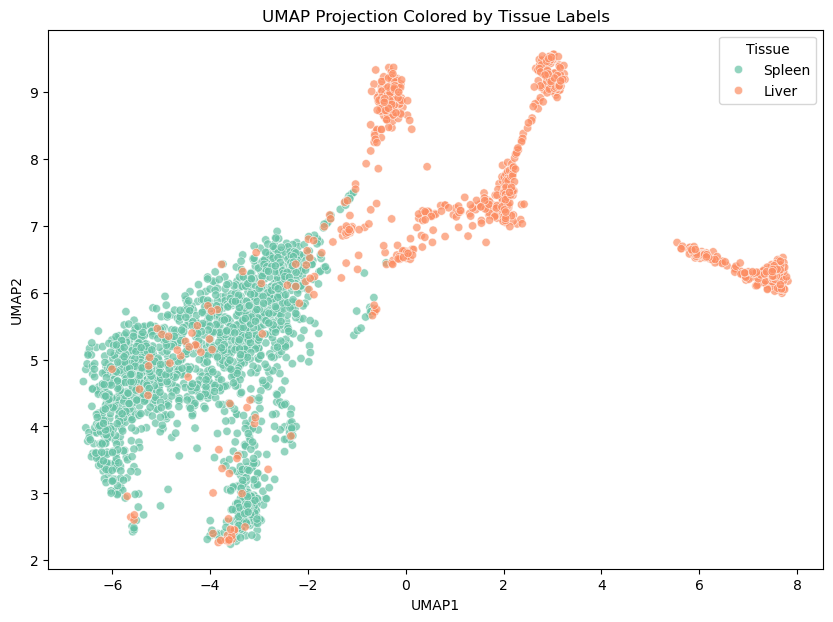

In [37]:
data_umap_with_labels = data_umap.copy()
data_umap_with_labels['tissue'] = log_transformed_data['tissue']
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=data_umap_with_labels,
    x='UMAP1',
    y='UMAP2',
    hue='tissue', 
    palette='Set2',
    alpha=0.7
)


plt.title("UMAP Projection Colored by Tissue Labels")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title='Tissue')
plt.show()


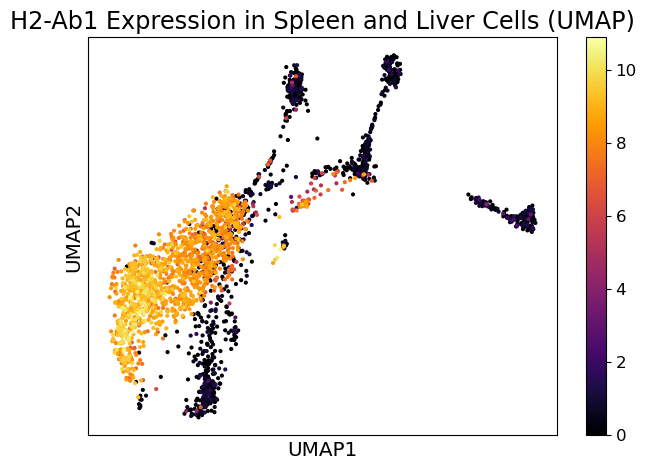

In [38]:
import scprep
import matplotlib.pyplot as plt



expression = scprep.select.select_cols(log_transformed_data.drop(columns=['tissue']), exact_word='H2-Ab1')
sort_index = expression.sort_values().index
scprep.plot.scatter2d(
    data_umap.loc[sort_index],
    c=expression.loc[sort_index],
    shuffle=False,
    title='H2-Ab1 Expression in Spleen and Liver Cells (UMAP)',
    ticks=None,
    label_prefix='UMAP'
)
plt.show()


In [39]:
import scprep
import matplotlib.pyplot as plt

expression = scprep.select.select_cols(log_transformed_data.drop(columns=['tissue']), exact_word='Coro1a')

sort_index = expression.sort_values().index


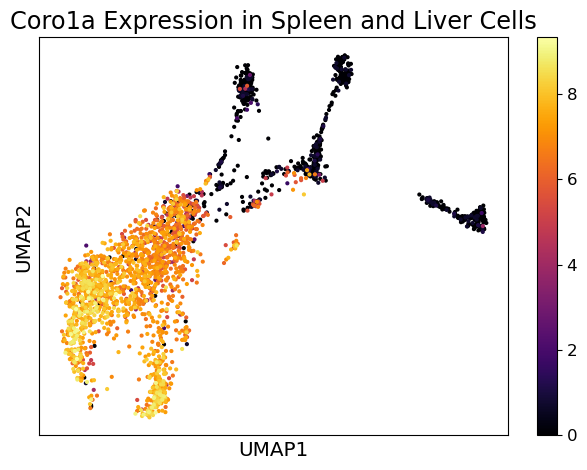

In [40]:
scprep.plot.scatter2d(data_umap.loc[sort_index], 
                      c=expression.loc[sort_index], 
                      shuffle=False, 
                      title='Coro1a Expression in Spleen and Liver Cells', 
                      label_prefix='UMAP', 
                      ticks=None)
plt.show()


In [41]:
spleen_umap = data_umap[log_transformed_data['tissue'] == 'Spleen']
liver_umap = data_umap[log_transformed_data['tissue'] == 'Liver']

spleen_pca = data_pca[log_transformed_data['tissue'] == 'Spleen']
liver_pca = data_pca[log_transformed_data['tissue'] == 'Liver']

spleen_data = log_transformed_data[log_transformed_data['tissue'] == 'Spleen'].drop(columns=['tissue'])
liver_data = log_transformed_data[log_transformed_data['tissue'] == 'Liver'].drop(columns=['tissue'])


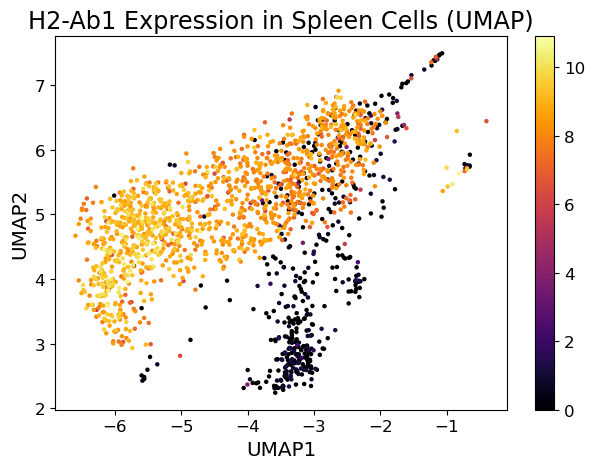

In [42]:
spleen_h2ab1 = scprep.select.select_cols(spleen_data, exact_word='H2-Ab1')

spleen_sort_index = spleen_h2ab1.sort_values().index

scprep.plot.scatter2d(spleen_umap.loc[spleen_sort_index], 
    c=spleen_h2ab1.loc[spleen_sort_index], 
    shuffle=False, 
    title='H2-Ab1 Expression in Spleen Cells (UMAP)', 
    label_prefix='UMAP'
)
plt.show()


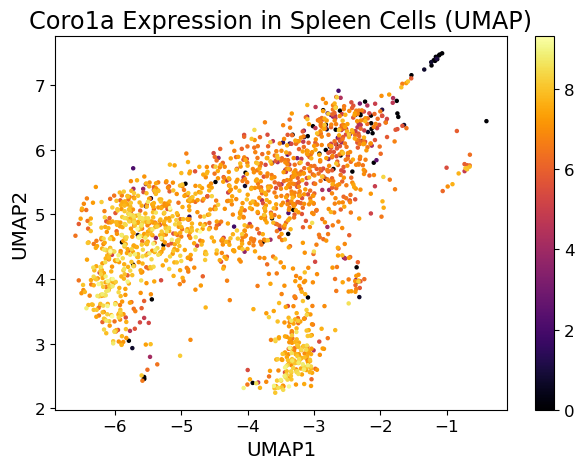

In [43]:
spleen_coro1a = scprep.select.select_cols(spleen_data, exact_word='Coro1a')

spleen_sort_index = spleen_coro1a.sort_values().index

scprep.plot.scatter2d(
    spleen_umap.loc[spleen_sort_index], 
    c=spleen_coro1a.loc[spleen_sort_index], 
    shuffle=False, 
    title='Coro1a Expression in Spleen Cells (UMAP)', 
    label_prefix='UMAP'
)
plt.show()


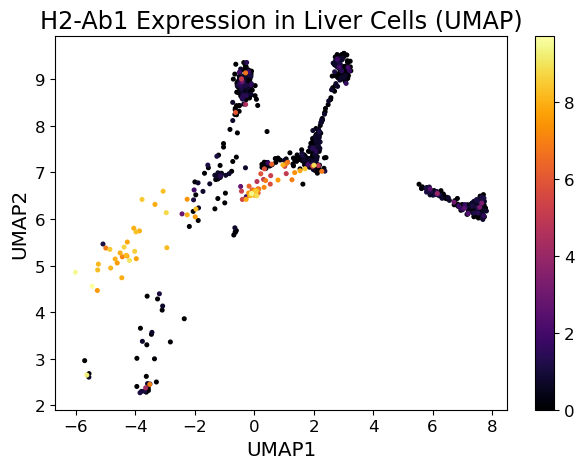

In [44]:
liver_h2ab1 = scprep.select.select_cols(liver_data, exact_word='H2-Ab1')
liver_sort_index = liver_h2ab1.sort_values().index

scprep.plot.scatter2d(
    liver_umap.loc[liver_sort_index], 
    c=liver_h2ab1.loc[liver_sort_index], 
    shuffle=False, 
    title='H2-Ab1 Expression in Liver Cells (UMAP)', 
    label_prefix='UMAP'
)
plt.show()


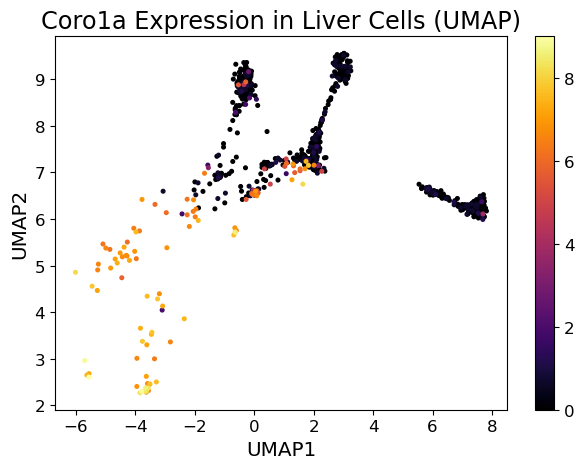

In [45]:
liver_coro1a = scprep.select.select_cols(liver_data, exact_word='Coro1a')
liver_sort_index = liver_coro1a.sort_values().index

scprep.plot.scatter2d(
    liver_umap.loc[liver_sort_index], 
    c=liver_coro1a.loc[liver_sort_index], 
    shuffle=False, 
    title='Coro1a Expression in Liver Cells (UMAP)', 
    label_prefix='UMAP'
)
plt.show()


In [46]:
import pandas as pd

annotations_path = "annotations_facs.csv"

try:
    annotations = pd.read_csv(annotations_path)
    print("Annotations File Loaded Successfully")
    print("Annotations Head:")
    print(annotations.head())
except FileNotFoundError:
    print(f"Annotations file not found at {annotations_path}. Please check the file path.")


Annotations File Loaded Successfully
Annotations Head:
  Neurog3>0_raw Neurog3>0_scaled                   cell  \
0           NaN              NaN  A1.B000610.3_56_F.1.1   
1           NaN              NaN  A1.B002764.3_38_F.1.1   
2           NaN              NaN  A1.B002771.3_39_F.1.1   
3           NaN              NaN   A1.D041914.3_8_M.1.1   
4           NaN              NaN   A1.D042253.3_9_M.1.1   

       cell_ontology_class cell_ontology_id  cluster.ids  \
0             bladder cell       CL:1001319            5   
1  bladder urothelial cell       CL:1001428            3   
2             bladder cell       CL:1001319            5   
3             bladder cell       CL:1001319            5   
4             bladder cell       CL:1001319            2   

                   free_annotation mouse.id mouse.sex plate.barcode  ...  \
0         Bladder mesenchymal cell   3_56_F         F       B000610  ...   
1  Luminal bladder epithelial cell   3_38_F         F       B002764  ...   
2

/tmp/ipykernel_642/750558402.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv(annotations_path)


Annotated Data Shape: (2345, 19251)
Annotated Data Head:
       0610005C13Rik  0610007C21Rik  0610007L01Rik  0610007N19Rik  \
33899            0.0       3.610918            0.0            0.0   
34168            0.0       0.000000            0.0            0.0   
33905            0.0       0.000000            0.0            0.0   
34179            0.0       3.332205            0.0            0.0   
34386            0.0       0.000000            0.0            0.0   

       0610007P08Rik  0610007P14Rik  0610007P22Rik  0610008F07Rik  \
33899       3.610918       0.000000            0.0            0.0   
34168       0.000000       3.465736            0.0            0.0   
33905       1.945910       0.000000            0.0            0.0   
34179       0.000000       0.000000            0.0            0.0   
34386       0.000000       0.000000            0.0            0.0   

       0610009B22Rik  0610009D07Rik  ...  subsetC  subsetC_cluster.ids  \
33899            0.0       0.000000  ..

<Figure size 1000x800 with 0 Axes>

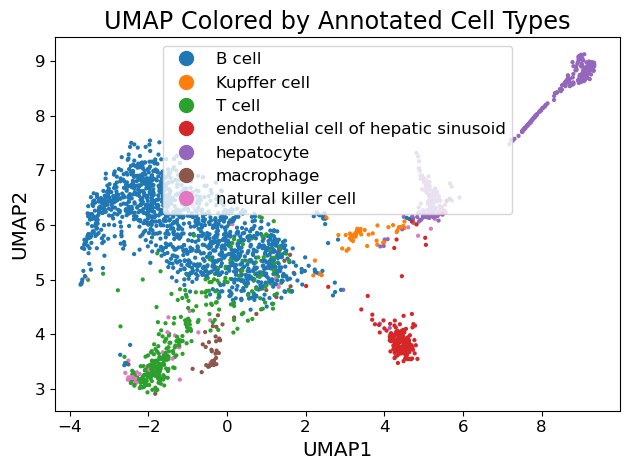

In [47]:
annotated_data = log_transformed_data.copy()
annotated_data = annotated_data.merge(
    annotations, left_index=True, right_on='cell', how='inner'
)

print("Annotated Data Shape:", annotated_data.shape)
print("Annotated Data Head:")
print(annotated_data.head())

import umap

umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(
    log_transformed_data.drop(columns=['tissue'])
)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=log_transformed_data.index)

umap_df = umap_df.merge(
    annotations[['cell', 'cell_ontology_class']], left_index=True, right_on='cell', how='inner'
)

plt.figure(figsize=(10, 8))
scprep.plot.scatter2d(
    umap_df, c=umap_df['cell_ontology_class'], legend=True, title="UMAP Colored by Annotated Cell Types"
)
plt.show()
